# California Housing Price Prediction

## Project Overview
This notebook implements a complete machine learning pipeline to predict California district median house values using various regression models (Linear Regression, Random Forest, and Lasso).

**Project Goals:**
- Compare linear vs non-linear regression approaches
- Identify key features driving house prices
- Evaluate model performance using residual analysis
- Generate insights on California housing market drivers


## 1. Imports and Setup


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# Setup
plots = '../plots/'
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')


## 2. Data Loading and Preprocessing


In [42]:
# Load dataset
df = pd.read_csv('../data/housing.csv')

# Rename columns for consistency
renamed_cols = {
    'longitude': 'Longitude',
    'latitude': 'Latitude',
    'housing_median_age': 'HouseAge',
    'total_rooms': 'TotalRooms',
    'total_bedrooms': 'TotalBedrooms',
    'population': 'Population',
    'households': 'Households',
    'median_income': 'MedInc',
    'median_house_value': 'MedHouseVal',
    'ocean_proximity': 'OceanProximity'
}

df = df.rename(columns=renamed_cols)

# Handle missing values
if df['TotalBedrooms'].isna().any():
    df['TotalBedrooms'] = df['TotalBedrooms'].fillna(df['TotalBedrooms'].median())

df.shape, df.head()


((20640, 10),
    Longitude  Latitude  HouseAge  TotalRooms  TotalBedrooms  Population  \
 0    -122.23     37.88      41.0       880.0          129.0       322.0   
 1    -122.22     37.86      21.0      7099.0         1106.0      2401.0   
 2    -122.24     37.85      52.0      1467.0          190.0       496.0   
 3    -122.25     37.85      52.0      1274.0          235.0       558.0   
 4    -122.25     37.85      52.0      1627.0          280.0       565.0   
 
    Households  MedInc  MedHouseVal OceanProximity  
 0       126.0  8.3252     452600.0       NEAR BAY  
 1      1138.0  8.3014     358500.0       NEAR BAY  
 2       177.0  7.2574     352100.0       NEAR BAY  
 3       219.0  5.6431     341300.0       NEAR BAY  
 4       259.0  3.8462     342200.0       NEAR BAY  )

### Dataset Info and Missing Values


In [43]:

df.info()


df.describe()

missing = df.isnull().sum()
missing_percent = (missing/len(df)) * 100
missing_df = pd.DataFrame({
    'missing count': missing,
    'percentage': missing_percent
})

missing_df[missing_df['missing count']>0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       20640 non-null  float64
 1   Latitude        20640 non-null  float64
 2   HouseAge        20640 non-null  float64
 3   TotalRooms      20640 non-null  float64
 4   TotalBedrooms   20640 non-null  float64
 5   Population      20640 non-null  float64
 6   Households      20640 non-null  float64
 7   MedInc          20640 non-null  float64
 8   MedHouseVal     20640 non-null  float64
 9   OceanProximity  20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,missing count,percentage


## 3. Exploratory Data Analysis (EDA)


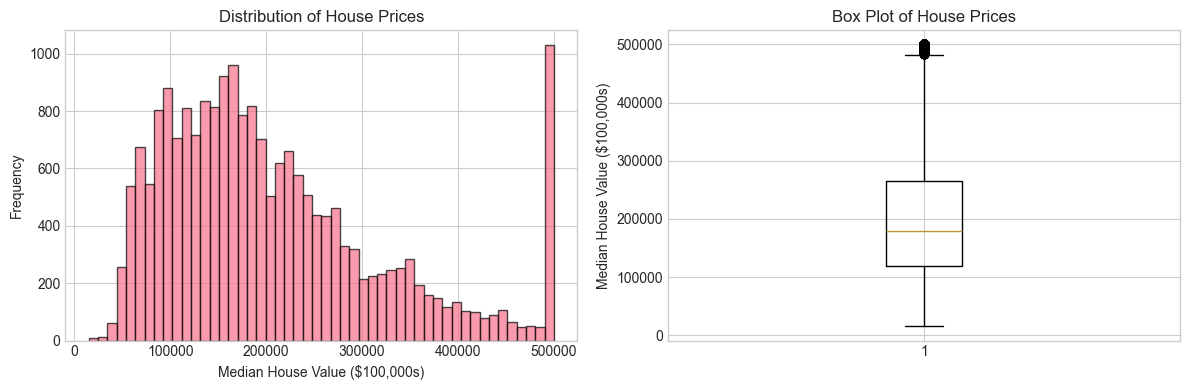

In [44]:
# Target variable distribution
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(df['MedHouseVal'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Median House Value ($100,000s)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')

plt.subplot(1, 2, 2)
plt.boxplot(df['MedHouseVal'])
plt.ylabel('Median House Value ($100,000s)')
plt.title('Box Plot of House Prices')
plt.tight_layout()
plt.show()



### Correlation Heatmap


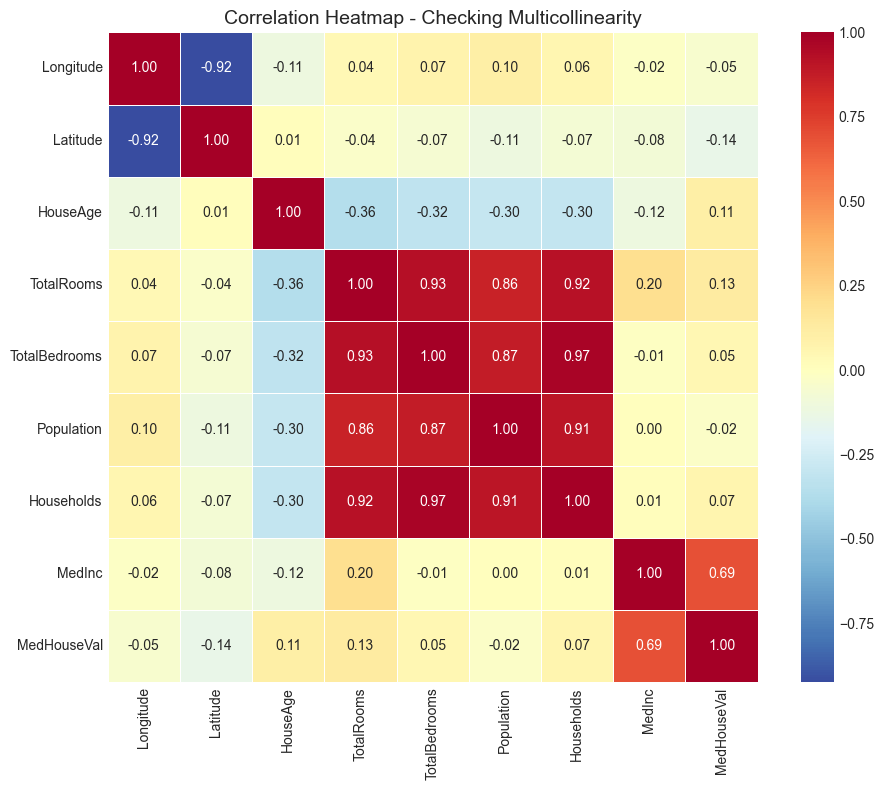

In [45]:
# Correlation matrix and heatmap (numeric columns only, before encoding)
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap - Checking Multicollinearity', fontsize=14)
plt.tight_layout()
plt.show()


### Geographic Visualization


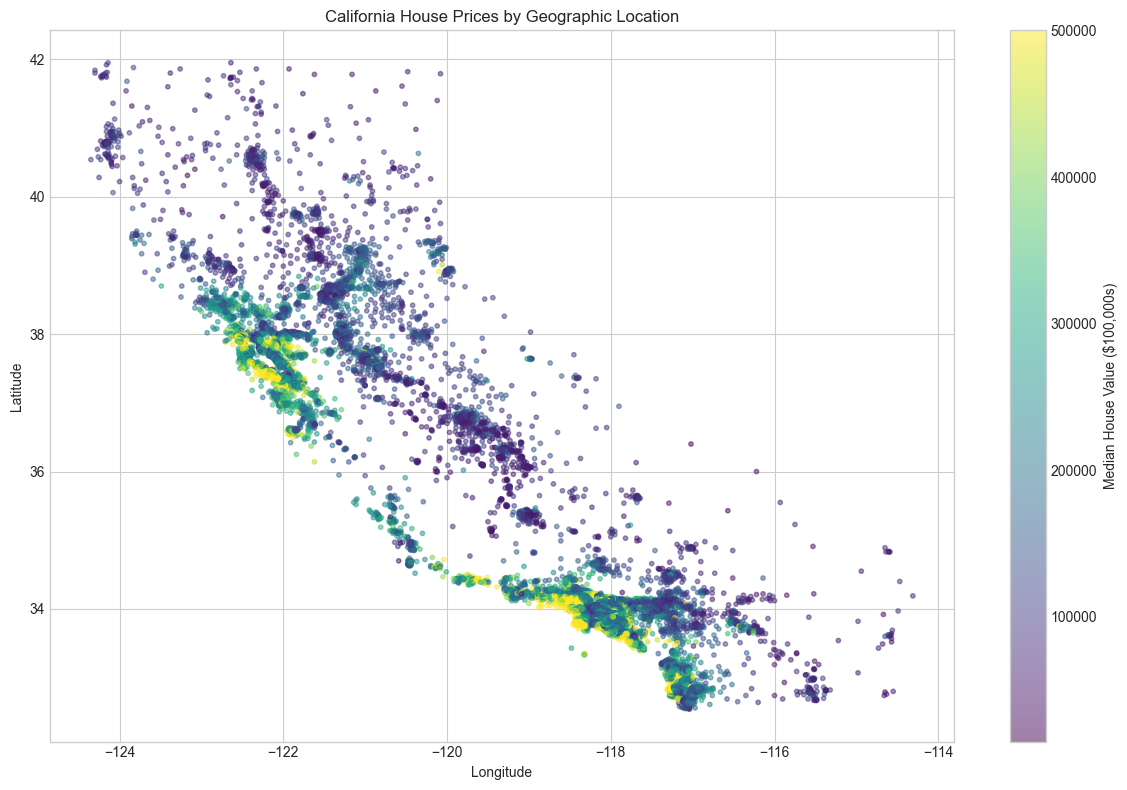

In [46]:
# Geographic scatter plot colored by house prices
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Longitude'], df['Latitude'], 
                      c=df['MedHouseVal'], cmap='viridis', 
                      alpha=0.5, s=10)
plt.colorbar(scatter, label='Median House Value ($100,000s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California House Prices by Geographic Location')
plt.tight_layout()
plt.show()


## 4. Feature Engineering


In [47]:
# Log-transform skewed features
log_features = ['MedInc', 'TotalRooms', 'TotalBedrooms', 'Population', 'Households']
for feature in log_features:
    df[f'log_{feature}'] = np.log1p(df[feature])

# One-hot encode categorical feature
df = pd.get_dummies(df, columns=['OceanProximity'], drop_first=True)

# Visualize log transform effects
for feature in log_features:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.histplot(df[feature], bins=40, ax=axes[0], color='#1f77b4')
    axes[0].set_title(f'{feature} (original)')
    sns.histplot(df[f'log_{feature}'], bins=40, ax=axes[1], color='#ff7f0e')
    axes[1].set_title(f'log_{feature}')
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('Count')
    fig.suptitle(f'Effect of log transform on {feature}')
    plt.tight_layout()
    plt.savefig(plots + f'log_transform_{feature}.png', dpi=150, bbox_inches='tight')
    plt.close()


## 5. Data Preparation for Modeling


In [51]:
# Prepare features and target
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.mean(), X_train_scaled.std()


(np.float64(1.8498654500594264e-16), np.float64(1.0))

## 6. Model Training and Evaluation


In [52]:
# Evaluation function
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Hyperparameter tuning for Random Forest
rf_params = {
    "max_depth": [5, 8, 15, None, 10],
    "max_features": [5, 7, "auto", 8],
    "min_samples_split": [2, 8, 15, 20],
    "n_estimators": [100, 200, 500, 1000]
}

randomcv_models = [
    ("RF", RandomForestRegressor(), rf_params)
]

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=10,
        cv=3,
        verbose=2,
        n_jobs=1
    )
    random.fit(X_train_scaled, y_train)
    model_param[name] = random.best_params_

model_param


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=8, max_features=7, min_samples_split=2, n_estimators=1000; total time=  16.4s
[CV] END max_depth=8, max_features=7, min_samples_split=2, n_estimators=1000; total time=  16.1s
[CV] END max_depth=8, max_features=7, min_samples_split=2, n_estimators=1000; total time=  15.5s
[CV] END max_depth=5, max_features=8, min_samples_split=8, n_estimators=500; total time=   6.1s
[CV] END max_depth=5, max_features=8, min_samples_split=8, n_estimators=500; total time=   6.0s
[CV] END max_depth=5, max_features=8, min_samples_split=8, n_estimators=500; total time=   5.9s
[CV] END max_depth=15, max_features=8, min_samples_split=8, n_estimators=1000; total time=  28.2s
[CV] END max_depth=15, max_features=8, min_samples_split=8, n_estimators=1000; total time=  28.3s
[CV] END max_depth=15, max_features=8, min_samples_split=8, n_estimators=1000; total time=  26.5s
[CV] END max_depth=15, max_features=7, min_samples_split=2, n_esti

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~

{'RF': {'n_estimators': 1000,
  'min_samples_split': 8,
  'max_features': 8,
  'max_depth': 15}}


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 65961.0200
- Mean Absolute Error: 47763.2709
- R2 Score: 0.6745
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 69361.4113
- Mean Absolute Error: 49932.8457
- R2 Score: 0.6329


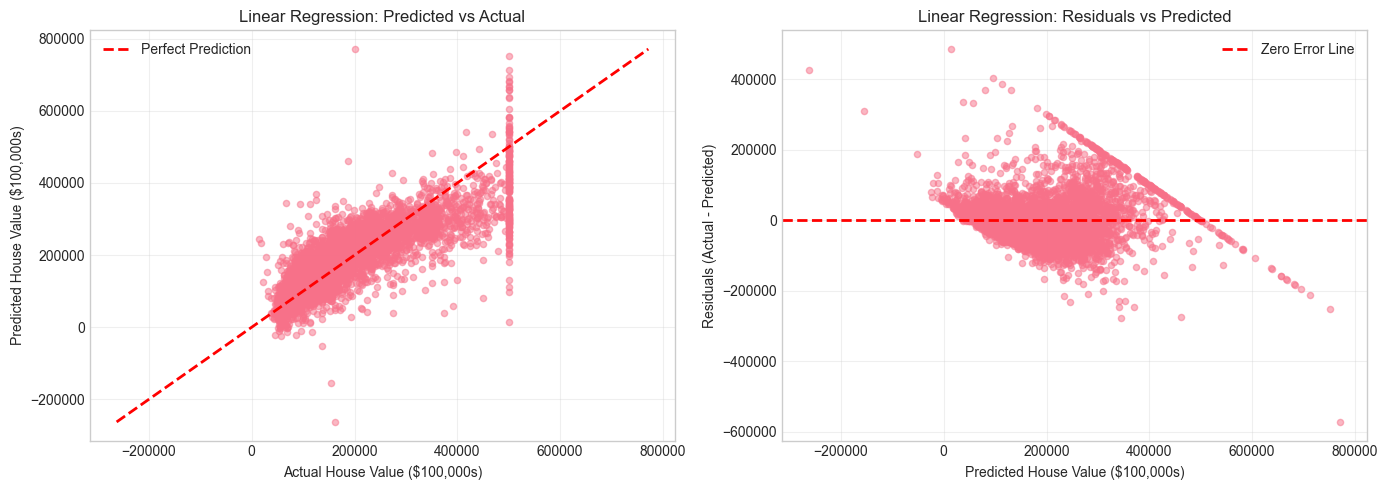


Random Forest
Model performance for Training set
- Root Mean Squared Error: 38411.9666
- Mean Absolute Error: 26285.6008
- R2 Score: 0.8896
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 52722.8214
- Mean Absolute Error: 35020.9053
- R2 Score: 0.7879


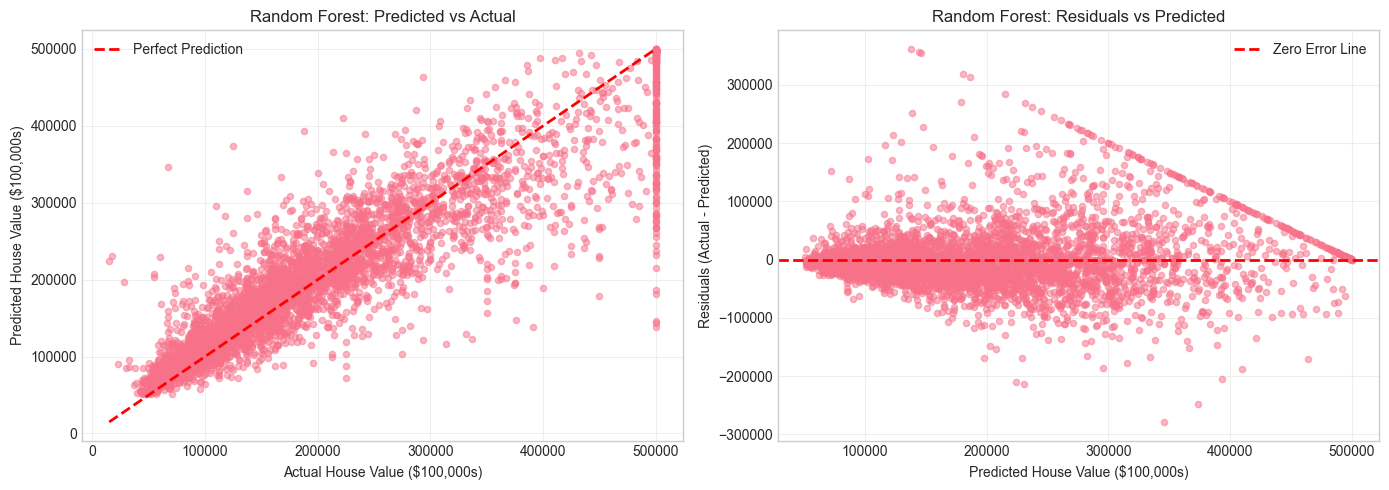


Lasso Regression
Model performance for Training set
- Root Mean Squared Error: 65961.0201
- Mean Absolute Error: 47763.2478
- R2 Score: 0.6745
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 69361.1274
- Mean Absolute Error: 49932.6696
- R2 Score: 0.6329


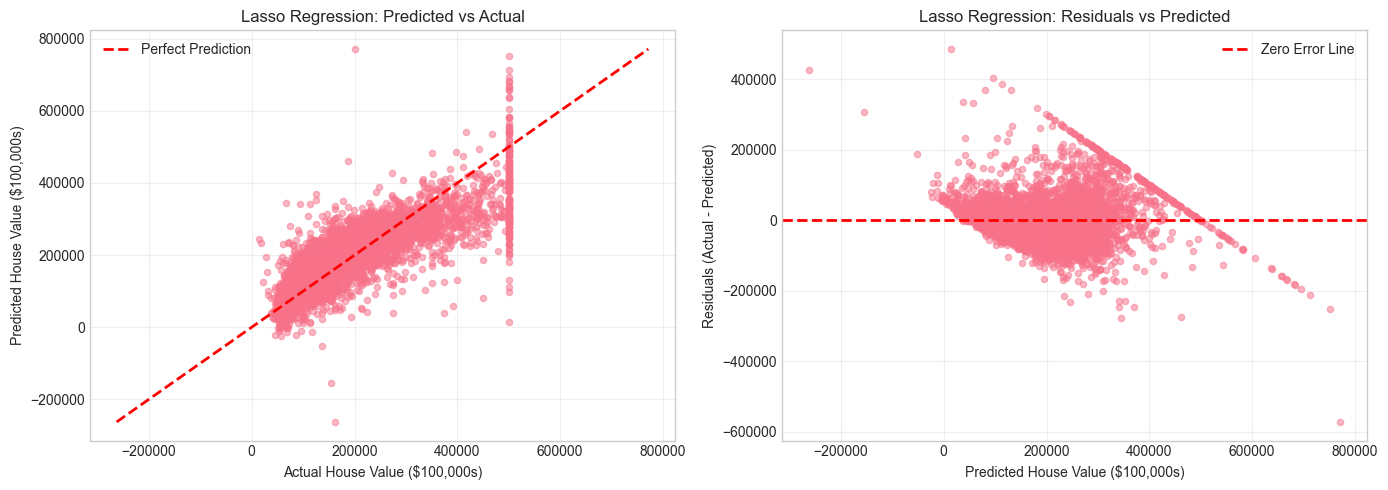

In [55]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=1000, min_samples_split=20, max_features=7, max_depth=15),
    "Lasso Regression": Lasso(alpha=0.1, max_iter=1000)
}

# Store results for comparison
model_results = []
rf_model = None

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Store results
    model_results.append({
        'Model': model_name,
        'Train_RMSE': model_train_rmse,
        'Test_RMSE': model_test_rmse,
        'Train_R2': model_train_r2,
        'Test_R2': model_test_r2,
        'Train_MAE': model_train_mae,
        'Test_MAE': model_test_mae
    })
    
    # Store RF model for feature importance
    if model_name == "Random Forest":
        rf_model = model
    
    print(f"\n{model_name}")
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print('='*35)
    
    # Residual plots
    residuals_test = y_test - y_test_pred
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Predicted vs Actual
    axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=20)
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual House Value ($100,000s)')
    axes[0].set_ylabel('Predicted House Value ($100,000s)')
    axes[0].set_title(f'{model_name}: Predicted vs Actual')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residuals vs Predicted
    axes[1].scatter(y_test_pred, residuals_test, alpha=0.5, s=20)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error Line')
    axes[1].set_xlabel('Predicted House Value ($100,000s)')
    axes[1].set_ylabel('Residuals (Actual - Predicted)')
    axes[1].set_title(f'{model_name}: Residuals vs Predicted')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    filename = f'residual_plots_{model_name.replace(" ", "_")}.png'
    plt.savefig(plots + filename, dpi=150, bbox_inches='tight')
    plt.show()


## 7. Feature Importance Analysis


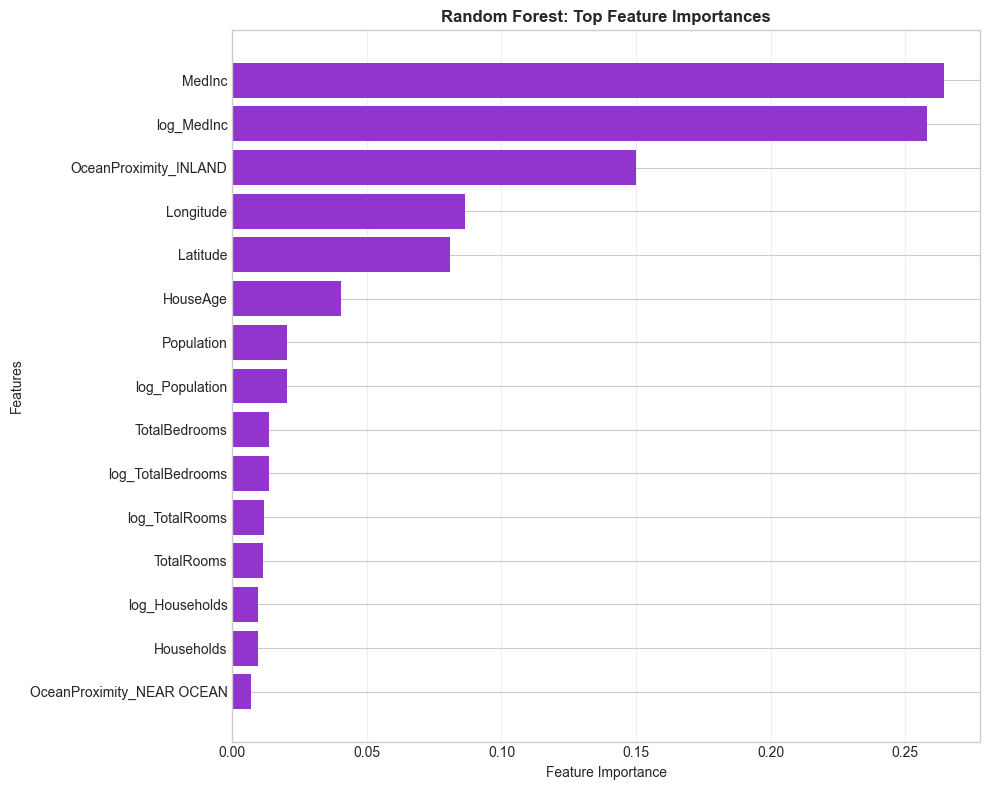

In [59]:
# Random Forest Feature Importance
importance_df = None  # Initialize to avoid NameError
if rf_model is not None:
    feature_importance = rf_model.feature_importances_
    feature_names = X.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 features
    top_n = min(15, len(importance_df))
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importance_df.head(top_n)['Importance'], color='#9234CE')
    plt.yticks(range(top_n), importance_df.head(top_n)['Feature'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Random Forest: Top Feature Importances', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots + 'rf_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    importance_df.head(10)


## 8. Model Comparison


In [57]:
# Model Comparison Table
comparison_df = pd.DataFrame(model_results)
comparison_df

# Save to CSV
comparison_df.to_csv('../model_comparison.csv', index=False)
